#Import Library

In [1]:
import nltk
import Sastrawi
import os
import json
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pastikan untuk mengunduh semua data NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#Data Loading

In [2]:
! wget https://raw.githubusercontent.com/gevabriel/dataset/main/indo_spam.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
df=pd.read_csv('indo_spam.csv')
df.head()

,Kategori,Pesan
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(
2,ham,Kalau mau bikin model/controller mending per a...
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  1143 non-null   object
 1   Pesan     1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


# Data Cleaning

In [5]:
Kategori = df['Kategori'].value_counts()
print("Jumlah data per kategori pesan:", Kategori)

Jumlah data per kategori pesan: Kategori
spam    574
ham     569
Name: count, dtype: int64


In [6]:
missing_values = df.isnull().sum()
print("Jumlah missing values per kolom:")
print(missing_values)

Jumlah missing values per kolom:
Kategori    0
Pesan       0
dtype: int64


In [7]:
duplicate_rows = df.duplicated()
print("Jumlah duplikasi data:", duplicate_rows.sum())

Jumlah duplikasi data: 1


In [8]:
print("Baris duplikat:")
print(df[duplicate_rows])

Baris duplikat:
    Kategori                                              Pesan
833      ham  bebas nama1, terus nanti kalau ada tgl libur, ...


In [9]:
df = df.drop_duplicates()

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
Kategori = df['Kategori'].value_counts()
print("Jumlah data per kategori Kategori:", Kategori)

Jumlah data per kategori Kategori: Kategori
spam    574
ham     568
Name: count, dtype: int64


In [12]:
df.replace({"Kategori": {"ham": 1, "spam": 0}}, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12880\2052400536.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Kategori": {"ham": 1, "spam": 0}}, inplace=True)


In [13]:
print(df)

      Kategori                                              Pesan
0            0  Plg Yth: Simcard anda mendptkan bonus poin plu...
1            1    Iya ih ko sedih sih gtau kapan lg ke bandung :(
2            1  Kalau mau bikin model/controller mending per a...
3            1  Selamat nama1. Semoga selalu menempuh hidup ya...
4            0  Tingkatkan nilai isi ulang Anda selanjutnya mi...
...        ...                                                ...
1137         1  Yg ragu sm bulet/datar atau yg pgn ikutan deba...
1138         1  Semangat yang ibu gita, ibu putri dan bapak ad...
1139         1  nama1, minta database kamu sama view dan contr...
1140         0  Dapatkan GRATIS 1 cappuccino (hot/ice) & Freza...
1141         1                            Silahkan tebak umurnya~

[1142 rows x 2 columns]


# Exploratory Data Analysis

In [14]:
df.head()

,Kategori,Pesan
0,0,Plg Yth: Simcard anda mendptkan bonus poin plu...
1,1,Iya ih ko sedih sih gtau kapan lg ke bandung :(
2,1,Kalau mau bikin model/controller mending per a...
3,1,Selamat nama1. Semoga selalu menempuh hidup ya...
4,0,Tingkatkan nilai isi ulang Anda selanjutnya mi...


**Penghapusan karakter br/**

In [15]:
import re

def remove_br_tags(text):
    pattern = re.compile(r'<br\s*/?>')
    return pattern.sub('', text)

df['Pesan'] = df['Pesan'].apply(remove_br_tags)

In [16]:
df.head()

,Kategori,Pesan
0,0,Plg Yth: Simcard anda mendptkan bonus poin plu...
1,1,Iya ih ko sedih sih gtau kapan lg ke bandung :(
2,1,Kalau mau bikin model/controller mending per a...
3,1,Selamat nama1. Semoga selalu menempuh hidup ya...
4,0,Tingkatkan nilai isi ulang Anda selanjutnya mi...


<Axes: xlabel='count', ylabel='Kategori'>

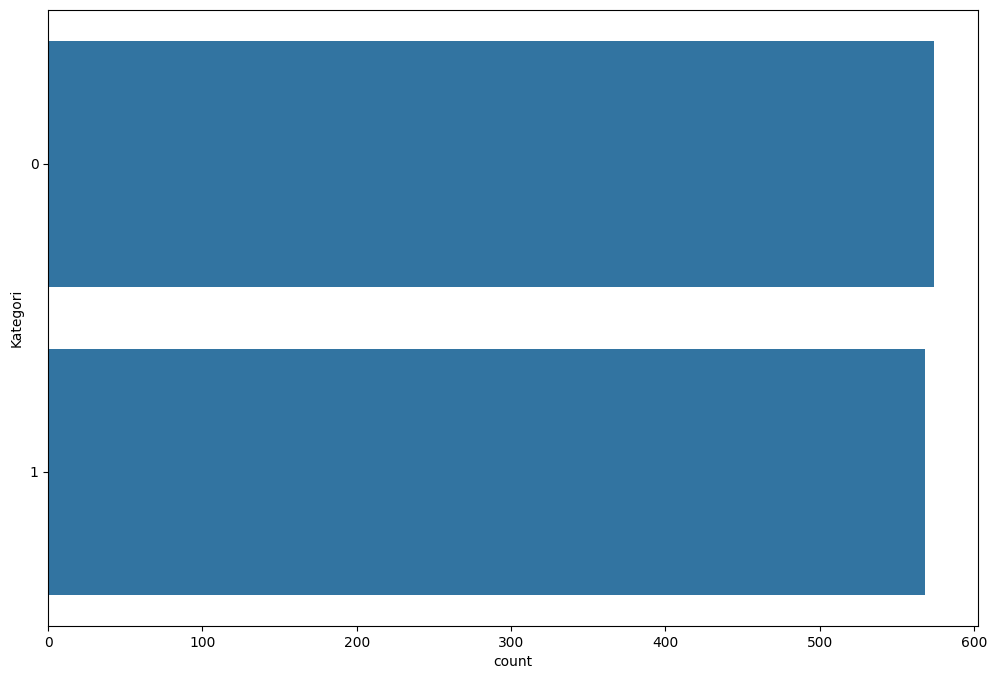

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(y = 'Kategori', data=df)

(-0.5, 799.5, 799.5, -0.5)

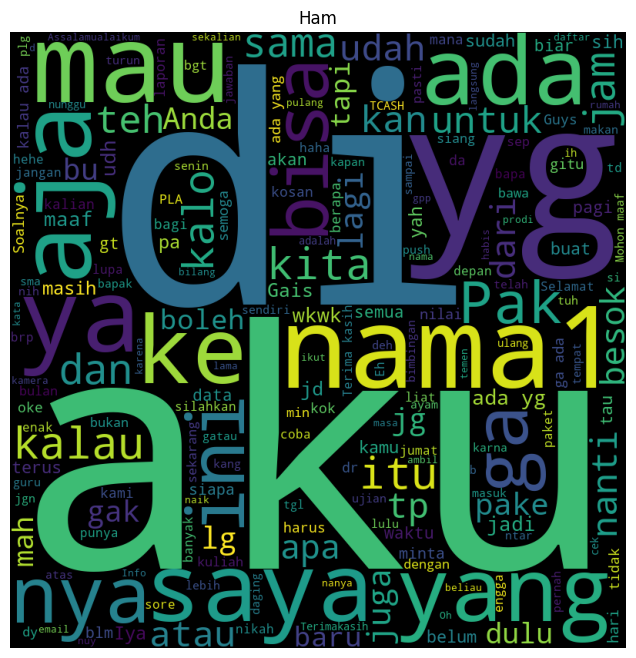

In [18]:
stopwords = set(STOPWORDS)
sentences=df['Pesan']

pos=' '.join(map(str,sentences[df['Kategori']==1]))
neg=' '.join(map(str,sentences[df['Kategori']==0]))

wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Ham')
plt.axis('off')

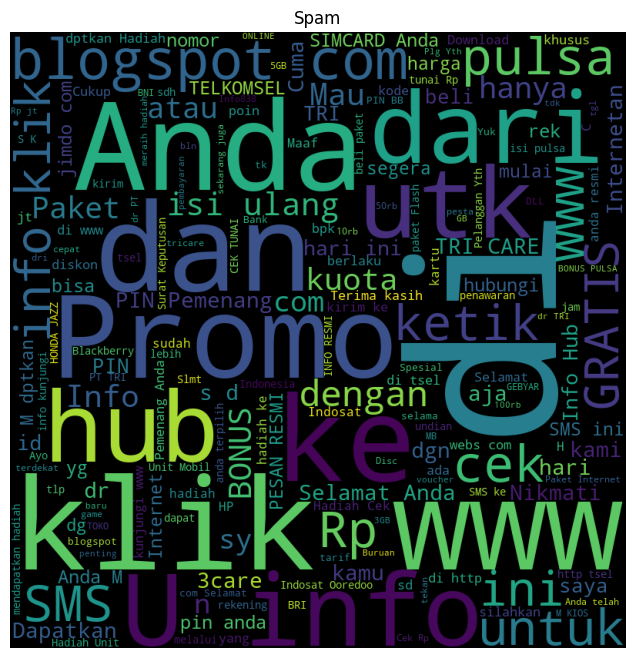

In [19]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(neg)

plt.imshow(wordcloud2)
plt.title('Spam')
plt.axis('off')

plt.show()

In [20]:
word_counts = df['Pesan'].apply(lambda x: len(str(x).split()))

In [21]:
word_counts.head()

0    18
1    11
2     8
3    11
4    18
Name: Pesan, dtype: int64

In [22]:
max_words = df['Pesan'].str.split().str.len().max()
print(f'Maximum kata pada kolom pesan: {max_words}')

Maximum kata pada kolom pesan: 63


# Pre Processing Data

In [23]:
review = ' '.join(df['Pesan'].tolist())

**Penghapusan Spesial Karakter**

In [24]:
def remove_special_characters(Pesan):
    # Regular expression untuk karakter khusus
    pattern = r'[^a-zA-Z0-9\s]'
    cleaned_review = re.sub(pattern, '', Pesan)
    return cleaned_review

In [25]:
df['Pesan'] = df['Pesan'].apply(remove_special_characters)

**Konversi kata ke huruf kecil**

In [26]:
df['Pesan'] = df['Pesan'].str.lower()

In [27]:
df.head()

,Kategori,Pesan
0,0,plg yth simcard anda mendptkan bonus poin plus...
1,1,iya ih ko sedih sih gtau kapan lg ke bandung
2,1,kalau mau bikin modelcontroller mending per apa y
3,1,selamat nama1 semoga selalu menempuh hidup yan...
4,0,tingkatkan nilai isi ulang anda selanjutnya mi...


**Penghapusan Stopwords**

In [28]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('indonesian')
stop_words.extend(['yang','untuk','ke','pada','dan'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
      result.append(token)

  return result

In [30]:
df['clean'] = df['Pesan'].apply(preprocess)

In [31]:
df['clean'] = df['clean'].apply(lambda x: " ".join(x))
df.head()

,Kategori,Pesan,clean
0,0,plg yth simcard anda mendptkan bonus poin plus...,simcard mendptkan bonus poin plusplus drptindo...
1,1,iya ih ko sedih sih gtau kapan lg ke bandung,sedih gtau bandung
2,1,kalau mau bikin modelcontroller mending per apa y,bikin modelcontroller mending
3,1,selamat nama1 semoga selalu menempuh hidup yan...,selamat nama semoga menempuh hidup bahagia men...
4,0,tingkatkan nilai isi ulang anda selanjutnya mi...,tingkatkan nilai ulang minimal ribu paket mura...


**Stemming**

In [32]:
nltk.download('punkt')
porter = PorterStemmer()

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Terapkan fungsi ke kolom 'clean'
df['stemmed_text'] = df['clean'].apply(stem_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Kategori,Pesan,clean,stemmed_text
0,0,plg yth simcard anda mendptkan bonus poin plus...,simcard mendptkan bonus poin plusplus drptindo...,simcard mendptkan bonu poin plusplu drptindosa...
1,1,iya ih ko sedih sih gtau kapan lg ke bandung,sedih gtau bandung,sedih gtau bandung
2,1,kalau mau bikin modelcontroller mending per apa y,bikin modelcontroller mending,bikin modelcontrol mend
3,1,selamat nama1 semoga selalu menempuh hidup yan...,selamat nama semoga menempuh hidup bahagia men...,selamat nama semoga menempuh hidup bahagia men...
4,0,tingkatkan nilai isi ulang anda selanjutnya mi...,tingkatkan nilai ulang minimal ribu paket mura...,tingkatkan nilai ulang minim ribu paket murah ...


**Lemmatization**

In [33]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['lemmatized_text'] = df['clean'].apply(lemmatize_text)
df.head()

,Kategori,Pesan,clean,stemmed_text,lemmatized_text
0,0,plg yth simcard anda mendptkan bonus poin plus...,simcard mendptkan bonus poin plusplus drptindo...,simcard mendptkan bonu poin plusplu drptindosa...,simcard mendptkan bonus poin plusplus drptindo...
1,1,iya ih ko sedih sih gtau kapan lg ke bandung,sedih gtau bandung,sedih gtau bandung,sedih gtau bandung
2,1,kalau mau bikin modelcontroller mending per apa y,bikin modelcontroller mending,bikin modelcontrol mend,bikin modelcontroller mending
3,1,selamat nama1 semoga selalu menempuh hidup yan...,selamat nama semoga menempuh hidup bahagia men...,selamat nama semoga menempuh hidup bahagia men...,selamat nama semoga menempuh hidup bahagia men...
4,0,tingkatkan nilai isi ulang anda selanjutnya mi...,tingkatkan nilai ulang minimal ribu paket mura...,tingkatkan nilai ulang minim ribu paket murah ...,tingkatkan nilai ulang minimal ribu paket mura...


In [34]:
# split data into training data and test data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
print(train_data.shape)
print(test_data.shape)

(913, 5)
(229, 5)


In [36]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["Pesan"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["Pesan"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["Pesan"]), maxlen=200)

In [37]:
print(X_train)

[[   0    0    0 ...   41  133 1565]
 [   0    0    0 ... 1568   32  998]
 [   0    0    0 ... 1574  589 1575]
 ...
 [   0    0    0 ...  571 4535  827]
 [   0    0    0 ... 4536    4 4537]
 [   0    0    0 ...  503 4540 4541]]


In [38]:
print(X_test)

[[   0    0    0 ...  459   48    7]
 [   0    0    0 ...  909  694  204]
 [   0    0    0 ...  149 1343 1736]
 ...
 [   0    0    0 ...   48   32  220]
 [   0    0    0 ...  264  323  271]
 [   0    0    0 ... 2937  739  270]]


In [39]:
Y_train = train_data["Kategori"]
Y_test = test_data["Kategori"]

In [40]:
print(Y_train)

12      0
758     1
636     0
1108    0
743     0
       ..
1044    0
1095    1
1130    1
860     1
1126    0
Name: Kategori, Length: 913, dtype: int64


# Build Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Definisikan model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200)) # input_length ditambahkan untuk memastikan input shape
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

# Build the model with the specified input shape
model.build(input_shape=(None, 200))  # (batch_size, timesteps)

# Tampilkan summary dari model
model.summary()

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

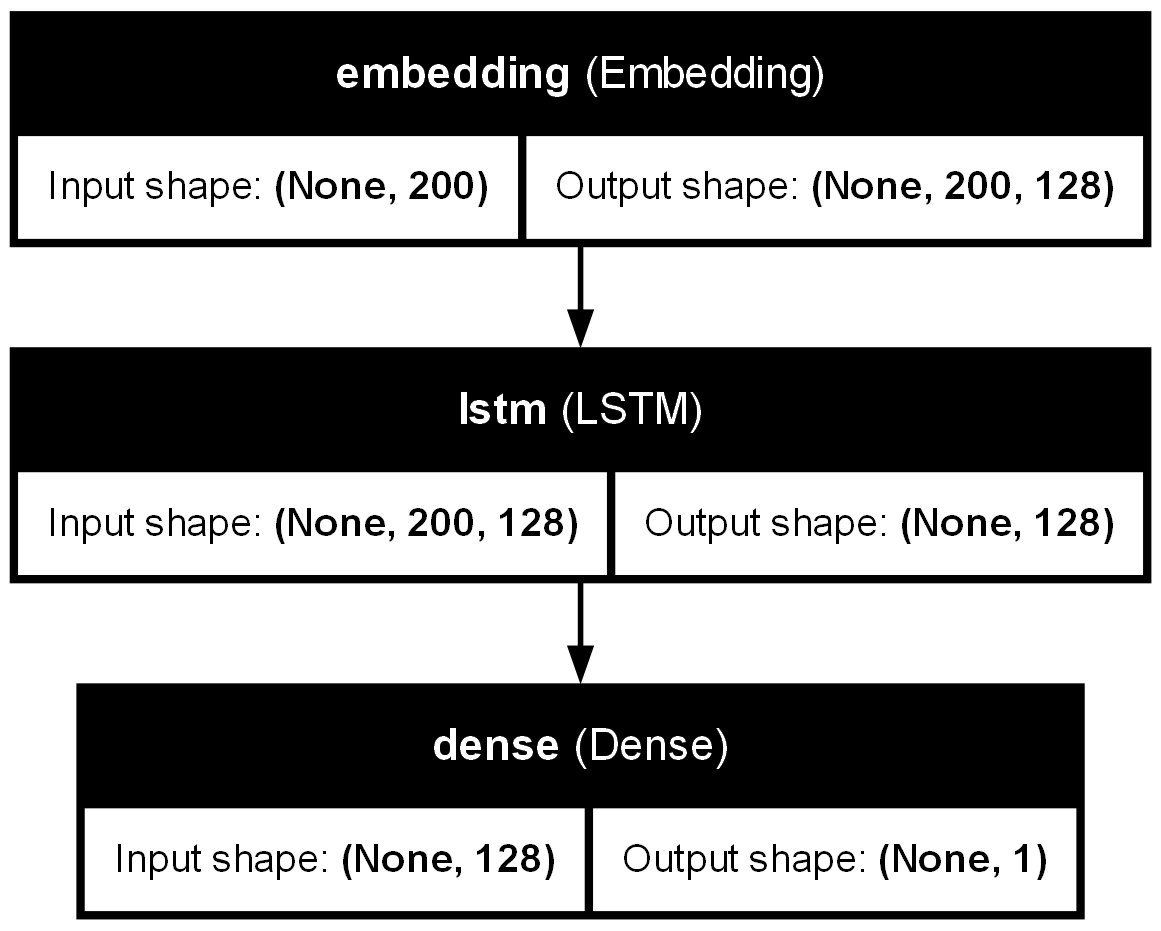

In [43]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
from IPython.display import Image

# Simpan diagram arsitektur model dalam bentuk file gambar
plot_model(model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

# Tampilkan gambar diagram model
Image(filename='model_lstm.png')

In [44]:
model.fit(X_train, Y_train, epochs=50, batch_size=1024, validation_split=0.3)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4085 - loss: 0.6942 - val_accuracy: 0.5949 - val_loss: 0.6841
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step - accuracy: 0.6573 - loss: 0.6823 - val_accuracy: 0.5657 - val_loss: 0.6704
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - accuracy: 0.6401 - loss: 0.6667 - val_accuracy: 0.6095 - val_loss: 0.6484
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 0.7121 - loss: 0.6410 - val_accuracy: 0.6204 - val_loss: 0.6161
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step - accuracy: 0.7230 - loss: 0.6063 - val_accuracy: 0.6168 - val_loss: 0.5790
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6917 - loss: 0.5678 - val_accuracy: 0.6131 - val_loss: 0.5517
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step - accuracy: 0.6761 - loss: 0.5372 - val_accuracy: 0.7117 - val_loss: 0.5144
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - accuracy: 0.7825 - loss: 0.5021 - val_accuracy: 0.8504 - val_loss: 0.461

In [45]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9680 - loss: 0.0810
Test Loss: 0.10786473751068115
Test Accuracy: 0.9563318490982056


In [46]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [47]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9563318777292577


In [48]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_binary = [int(round(p[0])) for p in y_pred]
report = classification_report(Y_test, y_pred_binary)
print(report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       119
           1       0.92      0.99      0.96       110

    accuracy                           0.96       229
   macro avg       0.96      0.96      0.96       229
weighted avg       0.96      0.96      0.96       229



In [49]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_binary = [int(round(p[0])) for p in y_pred]
cm = confusion_matrix(Y_test, y_pred_binary)
print(cm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[110   9]
 [  1 109]]


In [50]:
model.save('model.h5')

In [51]:
import pickle

# Menyimpan tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Memuat tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# TEST

In [52]:
def predict_kategori(Pesan):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([Pesan])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  Kategori = "ham" if prediction[0][0] > 0.33 else "spam"
  return Kategori, (1-(prediction[0][0]))*100

In [53]:
# example usage
new_pesan = "RP888 Platform Game Terbesar, www.rp888.tv merayakan ultah yg ke 10,  mengundang pelanggan Baru yang Terdaftar utk mengajukan isi ulang pulsa GRATIS Rp. 50.000 di layanan CS. Utk 10.000 org pertama."
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Pesan berikut adalah: spam
Persentase Spam:99.93%


In [54]:
# example usage
new_pesan = "Woy bre main yuk ke tangcity, bl lah sejam minimal. Itu klo lu ga sibuk yaaa, klo sibuk mah gausah"
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Pesan berikut adalah: ham
Persentase Spam:2.05%


In [55]:
# example usage
new_pesan = "Hai Dina, dari salon Blossom nih. Ingat ya, kamu ada jadwal perawatan wajah Jumat jam 3. Klo ada perubahan kabari. Makasih."
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Pesan berikut adalah: ham
Persentase Spam:1.63%


In [56]:
# example usage
new_pesan = "Siang Pak Agus. Janji ketemu konsultan Mandiri besok jam 2 siang ya. Bisa dtg ga? Pls konfirmasi. Thx."
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Pesan berikut adalah: ham
Persentase Spam:0.42%


In [57]:
# example usage
new_pesan = "Andi, Sabtu ini futsal jam 4 di lapangan biasa yuk? Ajak yg lain jg. Bisa ikut ga? Kasih tau ya biar booking."
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pesan berikut adalah: ham
Persentase Spam:0.61%


In [58]:
# example usage
new_pesan = "Bre ikut gua yuk, main billiard ke daruma tempat kita biasa main yuk! Ajak darma, ardhi, sama yang lain juga. Sabi ga lu? klo sabi gua booking"
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Pesan berikut adalah: ham
Persentase Spam:3.83%


In [59]:
# example usage
new_pesan = "Pagi Bu Rina, inget ya Ardi vaksin jam 10 di klinik. Jgn telat ya. Thx."
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Pesan berikut adalah: ham
Persentase Spam:0.55%


In [60]:
# example usage
new_pesan = "Hai Bud! Buku lo di Gramedia udh ready nih. Jgn lupa bawa bukti beli pas ambil. Makasih!"
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pesan berikut adalah: ham
Persentase Spam:1.25%


In [61]:
Peserta BPJS yth. Anda resmi menerima Dana Bantuan Rp 100 juta dari BPJS Kesehatan. Verifikasi di link di bawah ini# example usage
new_pesan = ""
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pesan berikut adalah: spam
Persentase Spam:99.92%


In [62]:
# example usage
new_pesan = "Halo Kak! Aku Winda Dri Team Giveaway BAIM Wong Anda Memenangkan Hadiah Uang 100jt dari kami info Klik:https://wa.me/+6287711234xxx"
Kategori, predict = predict_kategori(new_pesan)
print(f"Pesan berikut adalah: {Kategori}\nPersentase Spam:{predict:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pesan berikut adalah: spam
Persentase Spam:99.90%


#Kesimpulan

Dalam proyek ini, kami telah mengembangkan model Long Short-Term Memory (LSTM) untuk analisis pesan spam. Dengan menggunakan LSTM, kami mampu menangani tantangan dalam mengolah teks yang panjang dan memiliki konteks temporal yang penting. Beberapa poin utama yang dapat disimpulkan dari proyek ini adalah:

1. Efektivitas LSTM:
LSTM terbukti efektif dalam menangkap konteks temporal dan mengatasi masalah vanishing gradient, sehingga mampu memberikan hasil yang lebih akurat dalam analisis sentimen dibandingkan dengan model tradisional.
2. Kinerja Model:
Model LSTM yang dibangun berhasil mencapai target akurasi 86% dalam mengklasifikasikan sentimen ulasan sebagai positif atau negatif. Selain itu, model juga menunjukkan nilai presisi dan recall yang memuaskan, menunjukkan kemampuannya untuk secara konsisten mendeteksi kedua kategori sentimen.
3. Robustness:
Model yang dikembangkan menunjukkan ketahanan yang baik terhadap variasi dalam panjang ulasan, gaya bahasa, dan noise dalam data. Ini menunjukkan bahwa model mampu beradaptasi dengan berbagai kondisi dan tetap memberikan hasil yang andal.
4. Potensi Penerapan:
Dengan hasil yang memuaskan, model LSTM ini memiliki potensi untuk digunakan dalam aplikasi nyata, seperti rekomendasi film, analisis feedback pengguna, dan pemantauan sentimen publik terhadap film-film terbaru.

#Saran

Berdasarkan temuan dan hasil proyek ini, berikut adalah beberapa saran untuk pengembangan lebih lanjut dan penerapan model LSTM dalam analisis sentimen:

1. Peningkatan Kualitas Data:
Mengumpulkan lebih banyak data ulasan dan memastikan data tersebut memiliki label yang akurat dapat membantu meningkatkan kinerja model. Data tambahan dari berbagai sumber juga dapat membantu model untuk lebih generalisasi.
2. Penggunaan Teknik Preprocessing yang Lebih Lanjut:
Menerapkan teknik preprocessing yang lebih canggih, seperti lemmatization dan penghapusan stopwords yang lebih baik, dapat meningkatkan kualitas input data dan, dengan demikian, kinerja model.
3. Eksplorasi Model Lain:
Selain LSTM, model-model lain seperti Bidirectional LSTM (BiLSTM), Gated Recurrent Units (GRU), atau bahkan Transformer-based models seperti BERT dapat dieksplorasi untuk melihat apakah ada peningkatan kinerja yang signifikan.
4. Hyperparameter Tuning yang Lebih Mendalam:
Melakukan eksperimen dengan berbagai kombinasi hyperparameter untuk menemukan konfigurasi yang optimal dapat lebih meningkatkan akurasi dan robustness model.
5. Penerapan Teknik Data Augmentation:
Menggunakan teknik data augmentation untuk teks dapat membantu model menjadi lebih robust terhadap variasi data yang lebih besar.
6. Evaluasi Berkelanjutan:
Terus melakukan evaluasi dan monitoring terhadap model dengan data baru secara berkala untuk memastikan model tetap berkinerja baik dan relevan dengan perkembangan terbaru dalam opini publik.
Dengan mengikuti saran-saran ini, pengembangan lebih lanjut dari model LSTM untuk analisis sentimen dapat menghasilkan alat yang lebih canggih dan berguna dalam berbagai aplikasi praktis, memberikan wawasan yang lebih dalam dan akurat mengenai prediksi pesan spam atau ham.

In [63]:
%pip freeze > requirementsss.txt

Note: you may need to restart the kernel to use updated packages.


In [64]:
!python --version

Python 3.12.4
